# Работа с временными рядами и построение моделей с использованием линейной регрессии и градиентого бустинга

$_{\text{Коротков Алексей, 2021г}}$

[Датасет с Kaggle](https://www.kaggle.com/milanzdravkovic/pharma-sales-data) по продажам лекарств различного типа в одной сети сербских аптек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product   
from tqdm import tqdm_notebook
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
sns.set()

In [213]:
def update_data():
    data = pd.read_csv('salesweekly.csv')
    data['datum'] = pd.to_datetime(data.datum)
    data = data.sort_values(by='datum')
    return data
data = update_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   datum   302 non-null    datetime64[ns]
 1   M01AB   302 non-null    float64       
 2   M01AE   302 non-null    float64       
 3   N02BA   302 non-null    float64       
 4   N02BE   302 non-null    float64       
 5   N05B    302 non-null    float64       
 6   N05C    302 non-null    float64       
 7   R03     302 non-null    float64       
 8   R06     302 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 23.6 KB


In [3]:
def plot_rolling(n,year = False, plot_intervals=False, scale=1.96, plot_anomalies=False,acc=[],DATE=data.datum):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(DATE,acc[:365].values,label = 'Данные')
        plt.plot(rolling_mean[:365].values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(DATE,acc.values,label = 'Данные')
        plt.plot(DATE,rolling_mean.values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(indexes,anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

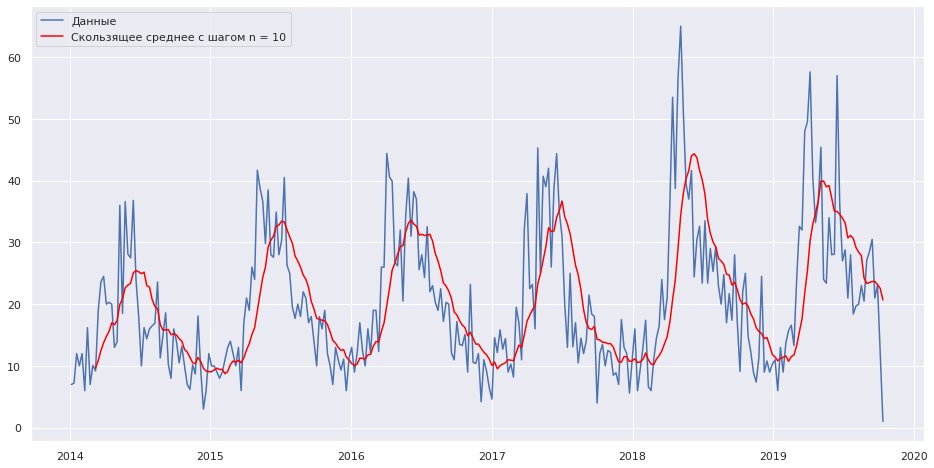

In [4]:
plot_rolling(10, acc = data.R06)

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

$\textbf{N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides}$

N05B - Psycholeptics drugs, Anxiolytic drugs

N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

R03 - Drugs for obstructive airway diseases

$\textbf{R06 - Antihistamines for systemic use}$

In [5]:
data

datum  M01AB   M01AE  N02BA    N02BE  N05B  N05C        R03    R06
0   2014-01-05  14.00  11.670  21.30  185.950  41.0   0.0  32.000000   7.00
1   2014-01-12  29.33  12.680  37.90  190.700  88.0   5.0  21.000000   7.20
2   2014-01-19  30.67  26.340  45.90  218.400  80.0   8.0  29.000000  12.00
3   2014-01-26  34.00  32.370  31.50  179.600  80.0   8.0  23.000000  10.00
4   2014-02-02  31.02  23.350  20.70  159.880  84.0  12.0  29.000000  12.00
..         ...    ...     ...    ...      ...   ...   ...        ...    ...
297 2019-09-15  35.51  30.977  19.65  178.375  67.2   5.0  30.000000  30.50
298 2019-09-22  46.84  25.396  24.40  248.250  31.2   3.0  26.000000  21.00
299 2019-09-29  34.01  22.498  26.60  336.700  61.2   1.0  40.416667  23.10
300 2019-10-06  38.70  32.502  19.25  249.450  69.0   5.0  30.000000  12.13
301 2019-10-13   7.67   6.237   3.50   95.100  26.0   2.0  12.000000   1.00

[302 rows x 9 columns]

In [6]:

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

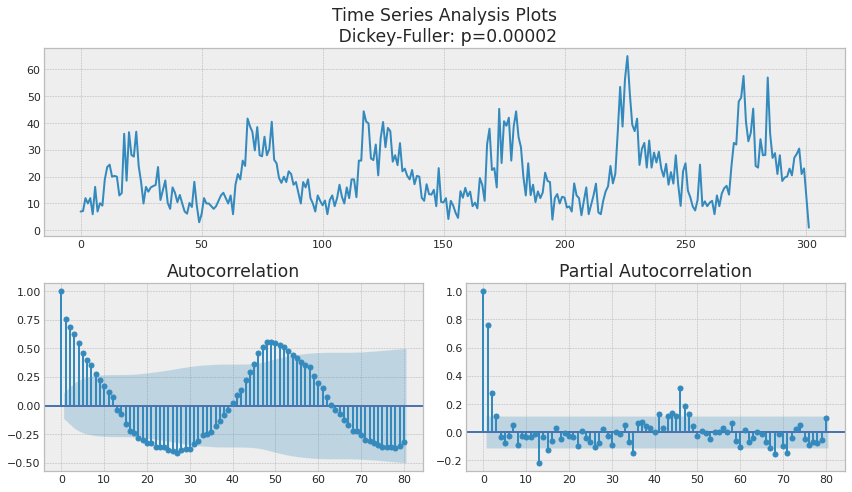

In [8]:
amount0 = data.R06
tsplot(amount0,80)

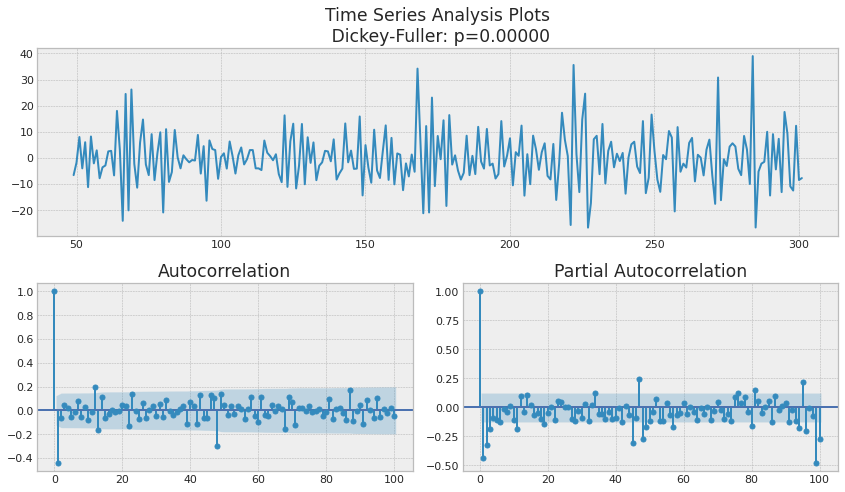

In [9]:
amount1 = amount0 - amount0.shift(48)
amount2 = amount1 - amount1.shift(1)
amount3 = amount2 - amount2.shift(1)
amount4 = amount3 - amount3.shift(1)
amount5 = amount4 - amount4.shift(1)
#amount6 = amount5 - amount5.shift(1)
#amount7 = amount6 - amount6.shift(21)
tsplot(amount2[49:],100)

In [10]:
#p = 3
#q = 1
#d = 1
#s = 48
#P = 1
#Q = 1
#D = 1

In [11]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 48

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [12]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data.R06, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [13]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiz

CPU times: user 21h 25min 25s, sys: 23h 15min 5s, total: 1d 20h 40min 30s
Wall time: 32min 22s


In [14]:
result_table.head(7)

parameters          aic
0  (3, 1, 0, 1)  1778.050691
1  (3, 1, 1, 1)  1778.585245
2  (4, 1, 0, 1)  1779.155636
3  (3, 2, 0, 1)  1779.344188
4  (3, 2, 1, 1)  1779.479575
5  (4, 1, 1, 1)  1779.765677
6  (4, 2, 0, 1)  1781.769145

In [15]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data.R06, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                R06   No. Observations:                  302
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 48)   Log Likelihood                -883.025
Date:                            Thu, 25 Mar 2021   AIC                           1778.051
Time:                                    14:28:35   BIC                           1799.251
Sample:                                         0   HQIC                          1786.580
                                            - 302                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3584      0.058      6.163      0.000       0.244       0.472
ar.L2          0.1926      0.062   

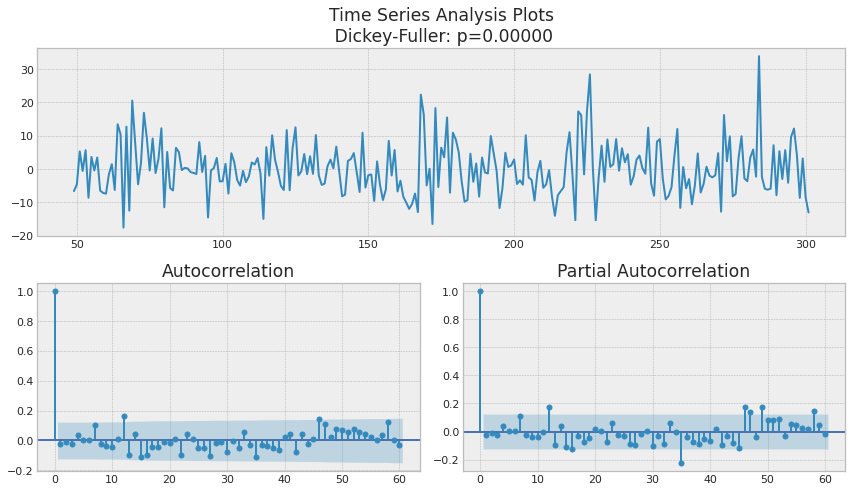

In [16]:
tsplot(best_model.resid[48+1:], lags=60)

In [17]:
def plotSARIMA(series, model, n_steps, s=48, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

In [18]:
mask = ['R06']

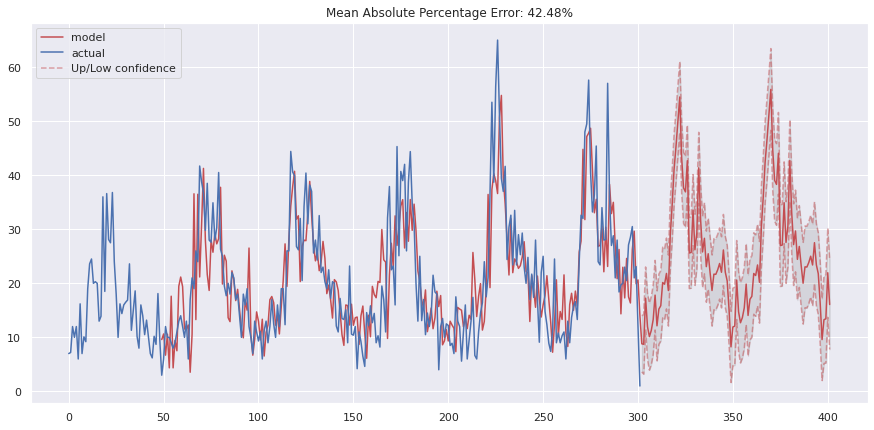

In [19]:
plotSARIMA(data[mask], best_model, 100, alpha=0.5)

In [162]:
# Adding the lag of the target variable from 100 steps back up to 400
data = pd.DataFrame(data.R06.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail(7)

y  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
295  27.10  20.50   23.0   20.0   19.7   18.4   28.0   21.0   28.8   27.0   
296  28.50  27.10   20.5   23.0   20.0   19.7   18.4   28.0   21.0   28.8   
297  30.50  28.50   27.1   20.5   23.0   20.0   19.7   18.4   28.0   21.0   
298  21.00  30.50   28.5   27.1   20.5   23.0   20.0   19.7   18.4   28.0   
299  23.10  21.00   30.5   28.5   27.1   20.5   23.0   20.0   19.7   18.4   
300  12.13  23.10   21.0   30.5   28.5   27.1   20.5   23.0   20.0   19.7   
301   1.00  12.13   23.1   21.0   30.5   28.5   27.1   20.5   23.0   20.0   

     lag_10  lag_49  lag_50  lag_51  lag_52  lag_53  
295   35.94    28.0    17.4    21.7    17.0    24.8  
296   27.00    17.0    28.0    17.4    21.7    17.0  
297   28.80     9.1    17.0    28.0    17.4    21.7  
298   21.00    22.0     9.1    17.0    28.0    17.4  
299   28.00    25.0    22.0     9.1    17.0    28.0  
300   18.40    14.8    25.0    22.0     9.1    17.0  
301   19.70    12.3    14.8    25.0    22.0     9.1

In [163]:
mask = ['date','min','max','average','wind','rain','eff']
temps = pd.read_csv('serbian_weather.csv')[mask]

In [164]:
week_weather = pd.read_csv('week_serbian_weather.csv')[mask]

In [165]:
data = data[:298]

In [166]:
data['min_temp'] = week_weather['min']
data['max_temp'] = week_weather['max']
data['average_temp'] = week_weather.average
data['wind'] = week_weather.wind
data['rain'] = week_weather.rain
data['eff'] = week_weather.eff
vals = list(range(1,5))+list(range(-5,0))
for i in vals:
    data["min_lag_{}".format(i)] = data.min_temp.shift(i)
    data["max_lag_{}".format(i)] = data.max_temp.shift(i)
    data["average_lag_{}".format(i)] = data.average_temp.shift(i)
    data["wind_lag_{}".format(i)] = data.wind.shift(i)
    data["rain_lag_{}".format(i)] = data.rain.shift(i)
    data["eff_lag_{}".format(i)] = data.eff.shift(i)
# take a look at the new dataframe 
data.head()

y  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  ...  \
0   7.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1   7.2    7.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
2  12.0    7.2    7.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
3  10.0   12.0    7.2    7.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
4  12.0   10.0   12.0    7.2    7.0    NaN    NaN    NaN    NaN    NaN  ...   

   average_lag_-2  wind_lag_-2  rain_lag_-2  eff_lag_-2  min_lag_-1  \
0            6.90         3.57         2.00        3.73        4.70   
1           -3.77         5.29         1.29       -9.37        4.93   
2            3.36         5.71         0.00       -1.81       -5.91   
3            9.57         3.57         0.86        6.41        0.11   
4           11.20         2.43         0.14        9.23        5.51   

   max_lag_-1  average_lag_-1  wind_lag_-1  rain_lag_-1  eff_lag_-1  
0       12.59            8.63         2.57         0.14        6.01  
1        9.04            6.90         3.57         2.00        3.73  
2       -1.10           -3.77         5.29         1.29       -9.37  
3        7.76            3.36         5.71         0.00       -1.81  
4       14.93            9.57         3.57         0.86        6.41  

[5 rows x 76 columns]

Подключим модули для построения линейной регрессии. Необходимо также учесть специфику наших данных.

### Кросс-валидация временных рядов

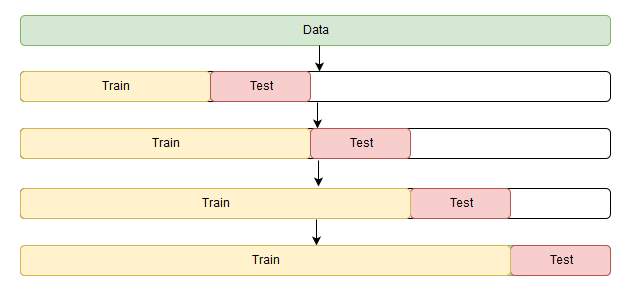

Временной ряд - это ряд $\{x_i(t_i):t_i-t_{i-1} = const\text{  }\forall i\in N \}$. 

Его специфика заключается в том, что каждое следующее значение, вообще говоря, зависит от предыдущего. Таким образом, при работе с временными рядами необходимо сохранять последователность точек. Именно для этого применяется кросс-валидация.

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [168]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Разделим данные на у - целевую переменную и множество независимых переменных Х

In [169]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

Создадим линейную регрессию. Принцип линейной регрессии заключается в минимизации функции ошибки, которая может быть разной.

### Функции ошибок

##### 1. Mean Absolute Error (MAE)

$MAE = \frac{1}{n}\sum \limits_{i=1}^{n}|\frac{\Phi_i - \Pi_i}{\Phi_i}|$,

где $\Phi_i - $фактическое значение, $\Pi - $предсказанное.

Выраженная в процентах MAE называется MAPE и лучше воспринимается человеком

##### 2. Mean Squared Error (MSE)

$MSE = \frac{1}{n}\sum \limits_{i=1}^{n}\left(\frac{\Phi_i - \Pi_i}{\Phi_i}\right)^2$,

##### 3. Mean Squared Logarithmic Error (MSLE) 

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+\Phi_i) - log(1+\Pi_i))^2$

Представляет собой тот же MSE, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

##### 4. Median Absolute Procent Error (MedAPE) 

$MedAE = median(|\Phi_1 - \Pi_1|, ... , |\Phi_n - \Pi_n|)$

Вычисляется аналогично MAPE, но вместо среднего вычисляется более устойчивое к выбросам медианное значение.

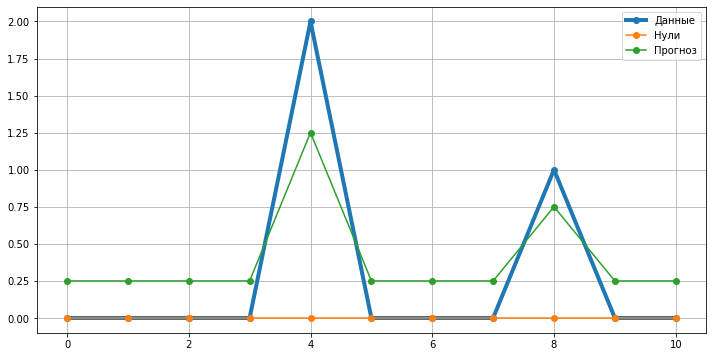

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
example = [0,0,0,0,2,0,0,0,1,0,0]
zeros = [0] * 11
fore = [0.25,0.25,0.25,0.25,1.25,0.25,0.25,0.25,0.75,0.25,0.25]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(example,'-o',linewidth = 4,label = 'Данные')
plt.plot(zeros,'-o',label = 'Нули')
plt.plot(fore,'-o',label = 'Прогноз')
plt.legend()

In [31]:
print('MAE для прогноза: ',mean_absolute_error(fore,example), '\nMAE для нулей: ',mean_absolute_error(zeros,example))
print('MSE для прогноза: ',mean_squared_error(fore,example), '\nMSE для нулей: ',mean_squared_error(zeros,example))

MAE для прогноза:  0.29545454545454547 
MAE для нулей:  0.2727272727272727
MSE для прогноза:  0.10795454545454546 
MSE для нулей:  0.45454545454545453


In [170]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [171]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,normas = True):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    if normas:
        coefs = coefs.loc[coefs.ne(0).all(axis=1)]
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

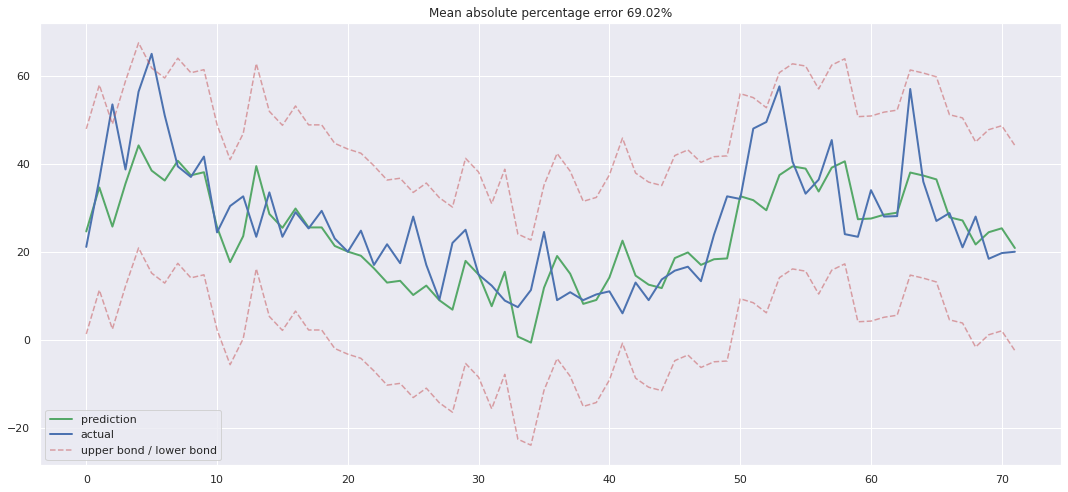

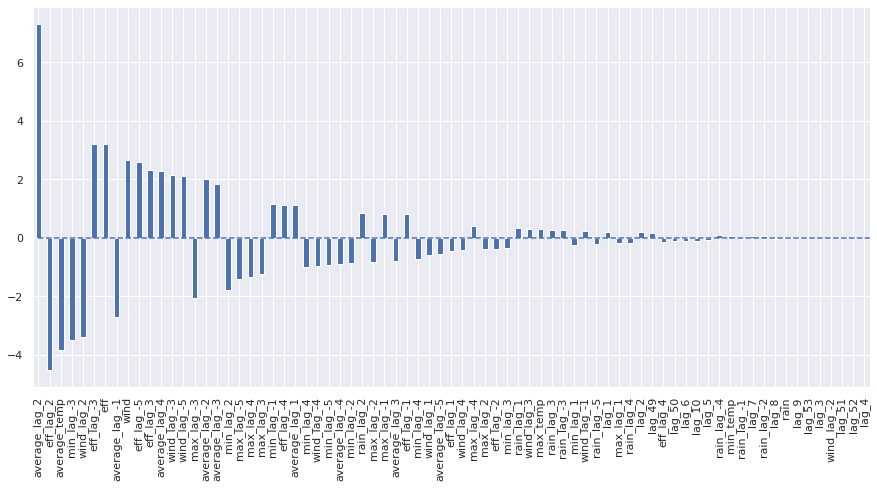

In [172]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

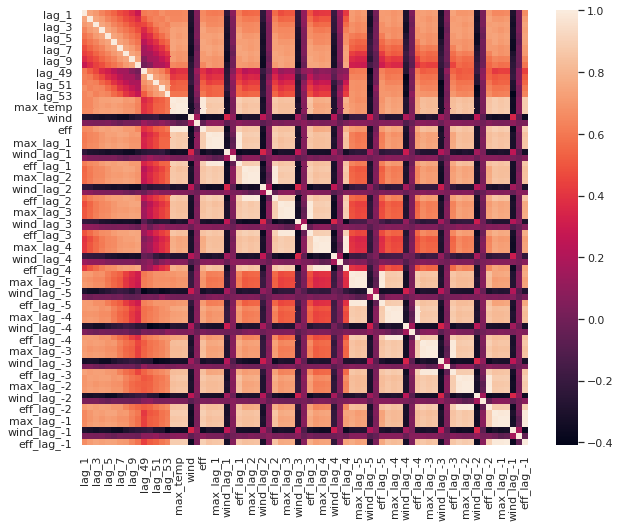

In [173]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

Улучшить модель можно регуляризацией. Рассмотрим три основных способа: Ridge-регрессия, Lasso-регрессия и метод эластичной сети, комбинирующий предыдущие два

$\textbf{Метод ридж-регрессии}$ заключается в минимизации суммы ошибки и квадратов весов

$\kappa = MAPE + \alpha \sum \limits_{i=1}^{n}\lambda_i^2$,

где $\lambda_i$ - веса признаков.

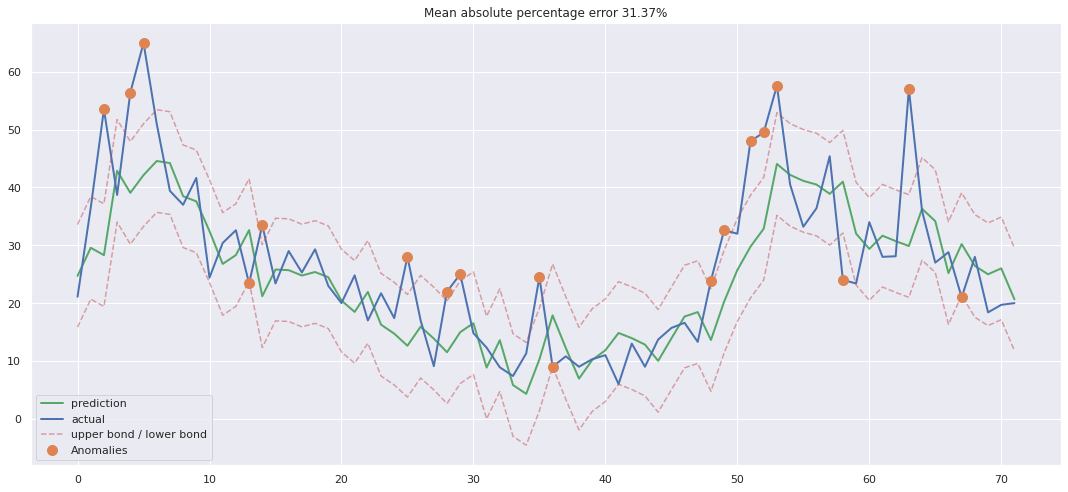

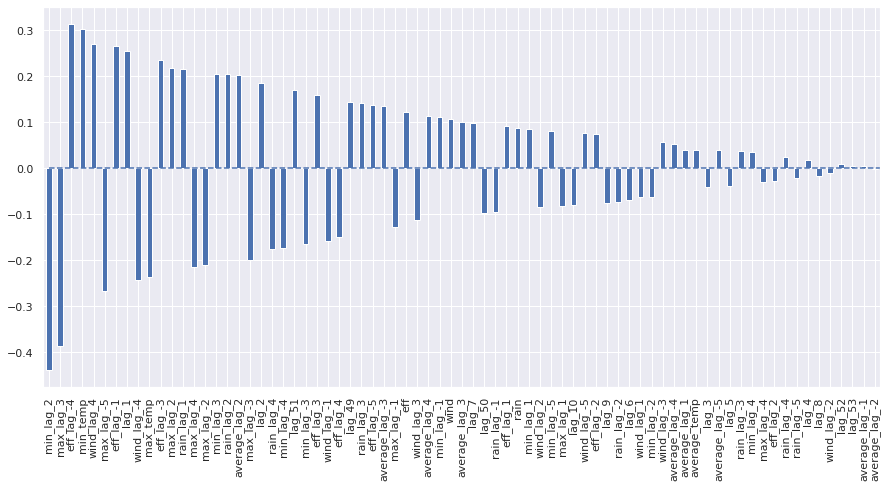

In [174]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(0, 100))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

$\textbf{Лассо регрессия}$ минимизирует уже сумму ошибки и модулей всех весов

$\kappa = MAPE + \alpha \sum \limits_{i=1}^{n}|\lambda_i|$.

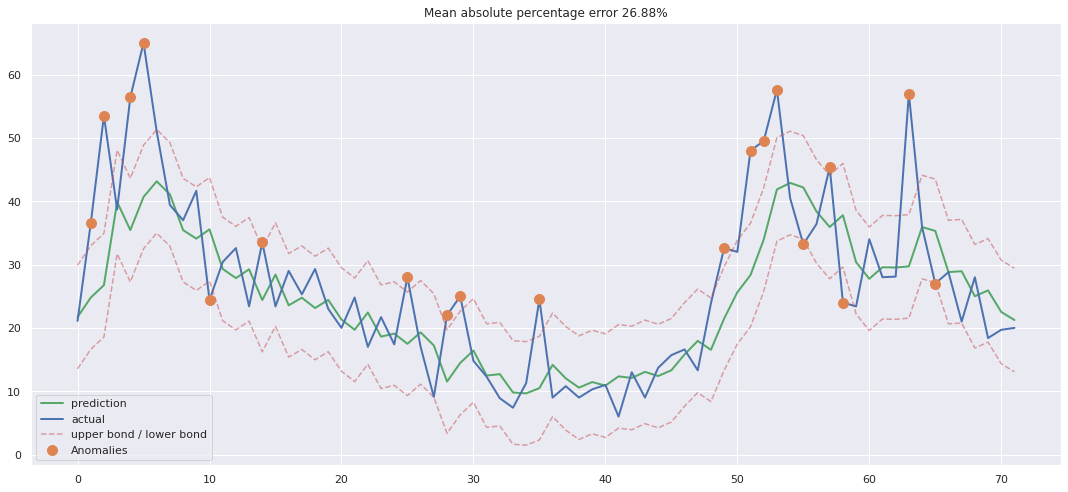

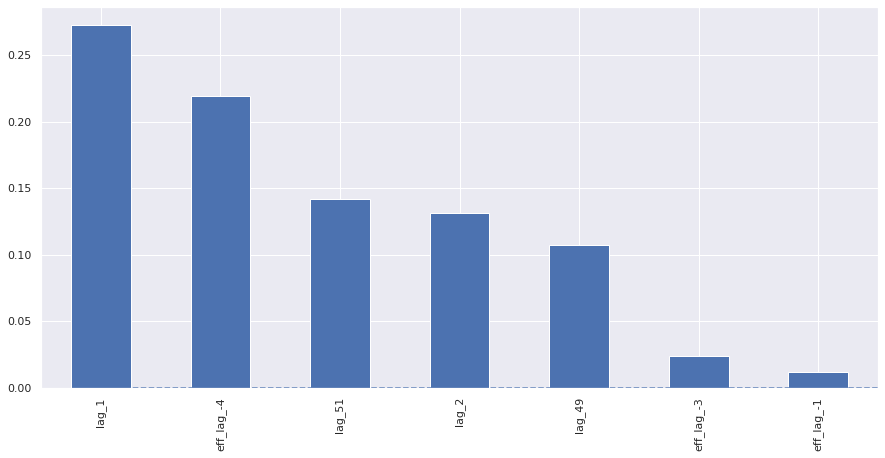

In [175]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso,normas = True)

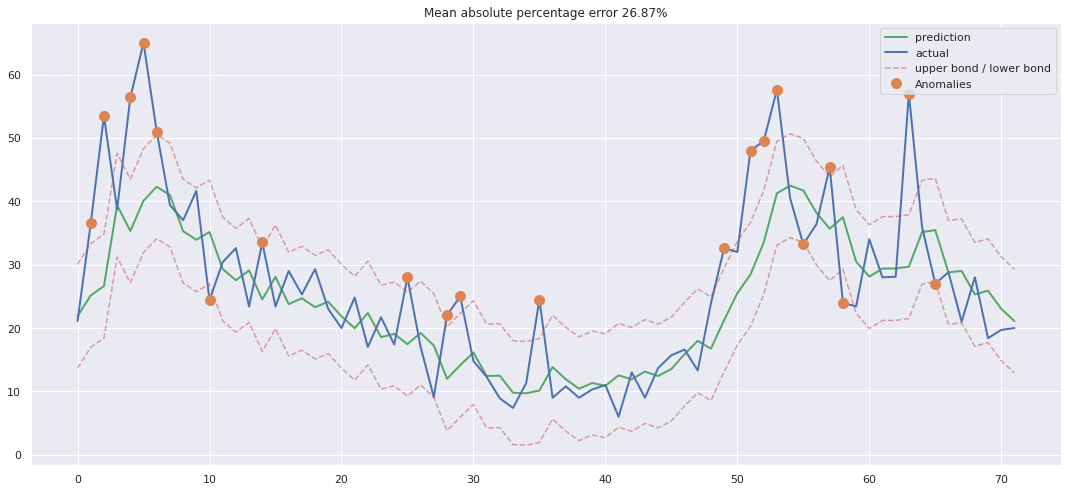

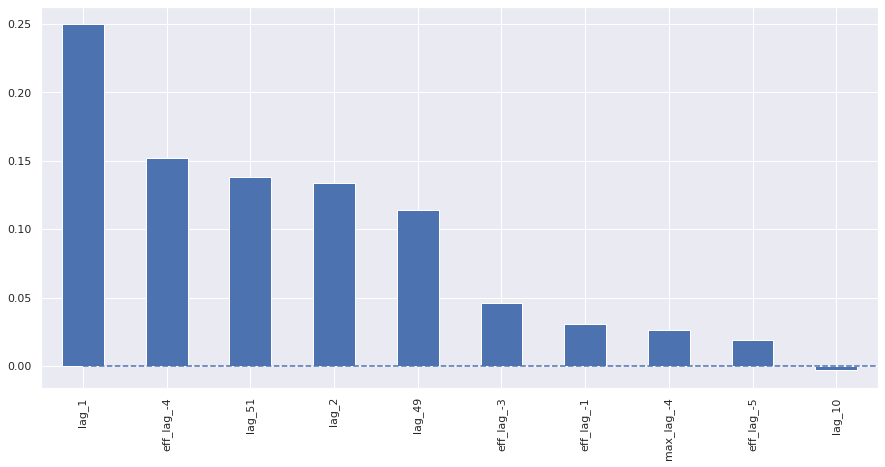

In [176]:
elasticnet = ElasticNetCV(cv=tscv, eps=0.00001,alphas=np.linspace(0, 100))
elasticnet.fit(X_train, y_train)

plotModelResults(elasticnet, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elasticnet,normas = True)

Далее я нсобирал данные о погоде в Сербии за период продаж

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


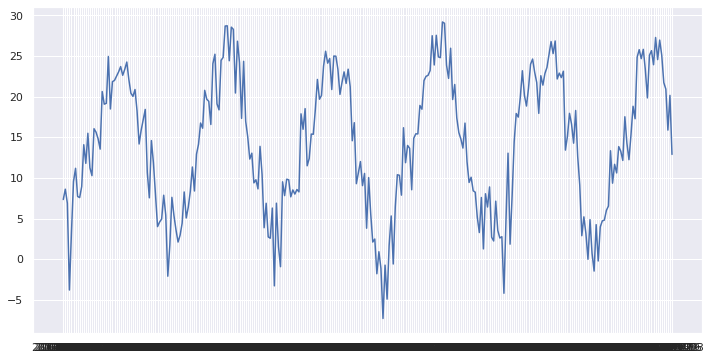

In [671]:
plt.figure(figsize=(12,6))
plt.plot(week_weather.date,week_weather.average)
plt.show()

In [139]:
data = pd.read_csv('salesweekly.csv')
data['datum'] = pd.to_datetime(data.datum)
data = data.sort_values(by='datum')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   datum   302 non-null    datetime64[ns]
 1   M01AB   302 non-null    float64       
 2   M01AE   302 non-null    float64       
 3   N02BA   302 non-null    float64       
 4   N02BE   302 non-null    float64       
 5   N05B    302 non-null    float64       
 6   N05C    302 non-null    float64       
 7   R03     302 non-null    float64       
 8   R06     302 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 23.6 KB


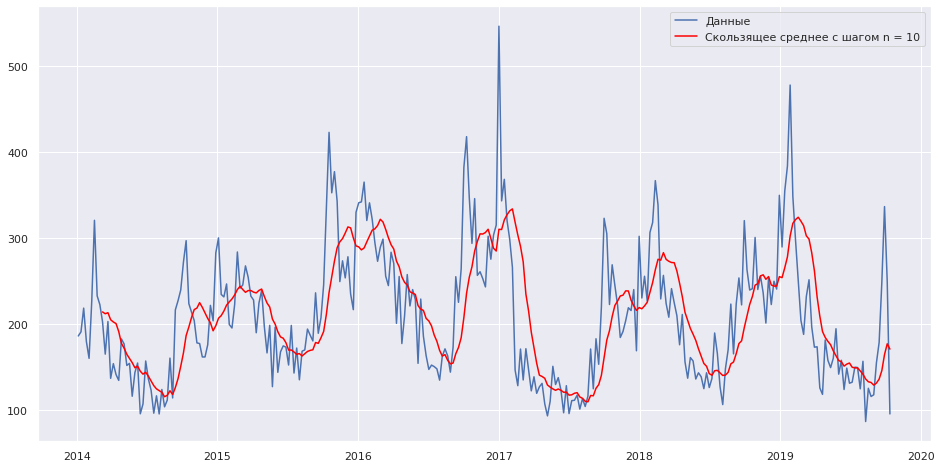

In [90]:
plot_rolling(10, acc = data.N02BE)

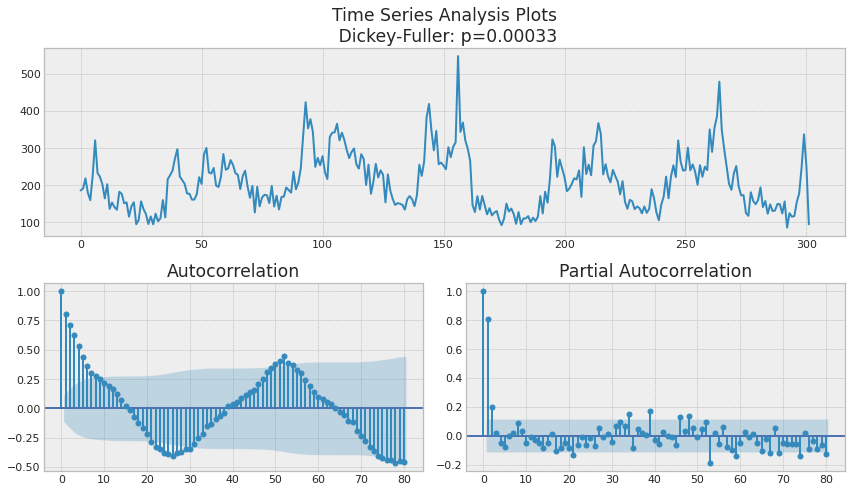

In [91]:
amount0 = data.N02BE
tsplot(amount0,80)

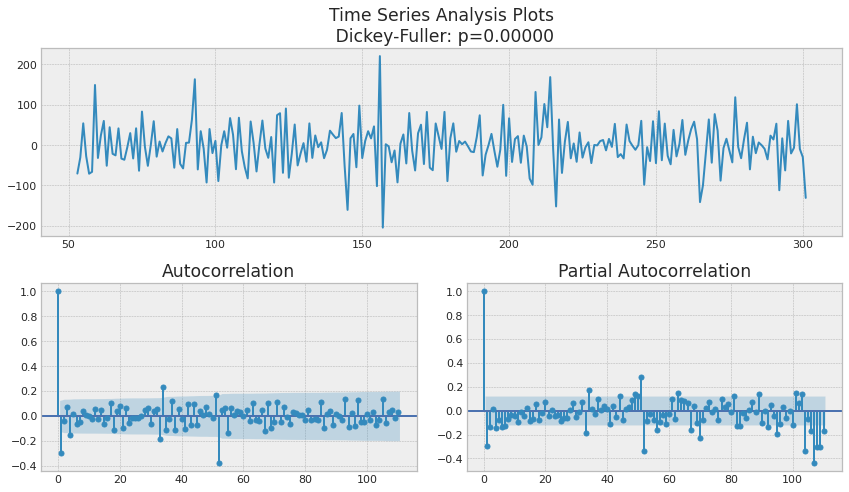

In [103]:
amount1 = amount0 - amount0.shift(52)
amount2 = amount1 - amount1.shift(1)
amount3 = amount2 - amount2.shift(1)
tsplot(amount2[53:],110)

In [104]:
#p = 1
#q = 4
#d = 1
#s = 52
#P = 2
#Q = 1
#D = 1

In [105]:
# setting initial values and some bounds for them
ps = range(1, 5)
d=1 
qs = range(1, 5)
Ps = range(0, 2)
D=1 
Qs = range(1, 2)
s = 52

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

In [107]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/32 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiz

CPU times: user 2d 22h 58min 12s, sys: 4d 7h 6min, total: 7d 6h 4min 12s
Wall time: 1h 28min 5s


In [108]:
result_table.head(7)

parameters          aic
0  (3, 4, 1, 1)  1723.033042
1  (4, 3, 1, 1)  1723.043512
2  (4, 3, 0, 1)  1724.044474
3  (2, 3, 0, 1)  1724.117841
4  (2, 1, 1, 1)  1724.435699
5  (3, 4, 0, 1)  1724.536613
6  (3, 3, 0, 1)  1724.537538

In [140]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data.N02BE, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                N02BE   No. Observations:                  302
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 52)   Log Likelihood               -1304.156
Date:                              Thu, 25 Mar 2021   AIC                           2628.311
Time:                                      18:14:26   BIC                           2663.486
Sample:                                           0   HQIC                          2642.470
                                              - 302                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2733      0.684      0.399      0.690      -1.068       1.615
ar.L2          0.74

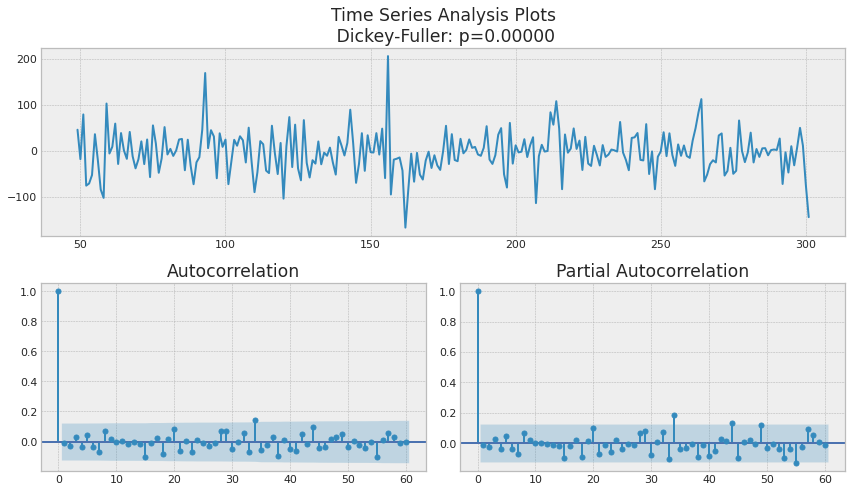

In [141]:
tsplot(best_model.resid[48+1:], lags=60)

In [142]:
mask = ['N02BE']

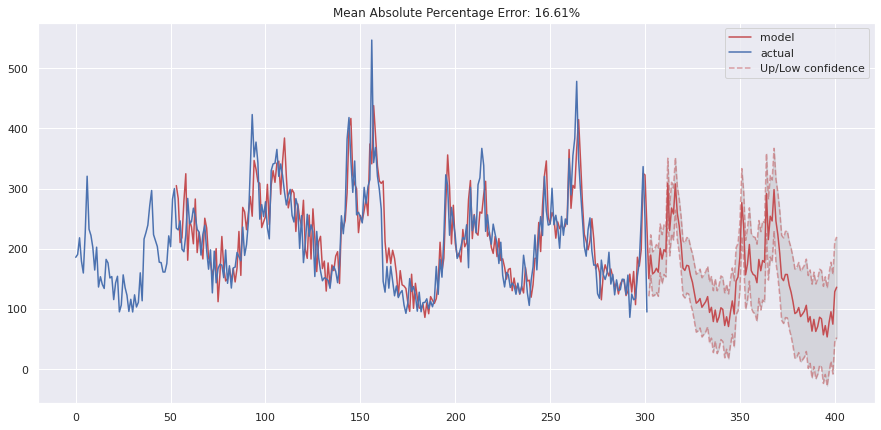

In [143]:
plotSARIMA(data[mask], best_model, 100, alpha=0.5,s=52)

In [376]:
# Adding the lag of the target variable from 100 steps back up to 400
data = update_data()
data = pd.DataFrame(data.N02BE.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail(7)

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6    lag_7  \
295  117.400  115.450  125.000   86.250  156.450  124.375  149.200  149.600   
296  154.755  117.400  115.450  125.000   86.250  156.450  124.375  149.200   
297  178.375  154.755  117.400  115.450  125.000   86.250  156.450  124.375   
298  248.250  178.375  154.755  117.400  115.450  125.000   86.250  156.450   
299  336.700  248.250  178.375  154.755  117.400  115.450  125.000   86.250   
300  249.450  336.700  248.250  178.375  154.755  117.400  115.450  125.000   
301   95.100  249.450  336.700  248.250  178.375  154.755  117.400  115.450   

       lag_8    lag_9   lag_10   lag_49   lag_50   lag_51   lag_52   lag_53  
295  132.050  130.900  148.500  222.162  253.550  223.200  165.100  223.100  
296  149.600  132.050  130.900  320.350  222.162  253.550  223.200  165.100  
297  149.200  149.600  132.050  262.950  320.350  222.162  253.550  223.200  
298  124.375  149.200  149.600  239.500  262.950  320.350  222.162  253.550  
299  156.450  124.375  149.200  241.000  239.500  262.950  320.350  222.162  
300   86.250  156.450  124.375  300.725  241.000  239.500  262.950  320.350  
301  125.000   86.250  156.450  240.100  300.725  241.000  239.500  262.950

In [179]:
mask = ['date','min','max','average','wind','rain','eff']
week_weather = pd.read_csv('week_serbian_weather.csv')[mask]

In [377]:
data = data[:298]

In [378]:
data['min_temp'] = week_weather['min']
data['max_temp'] = week_weather['max']
data['average_temp'] = week_weather.average
data['wind'] = week_weather.wind
data['rain'] = week_weather.rain
data['eff'] = week_weather.eff
vals = list(range(1,5))+list(range(-5,0))
for i in vals:
    data["min_lag_{}".format(i)] = data.min_temp.shift(i)
    data["max_lag_{}".format(i)] = data.max_temp.shift(i)
    data["average_lag_{}".format(i)] = data.average_temp.shift(i)
    data["wind_lag_{}".format(i)] = data.wind.shift(i)
    data["rain_lag_{}".format(i)] = data.rain.shift(i)
    data["eff_lag_{}".format(i)] = data.eff.shift(i)
# take a look at the new dataframe 
data.head()

y   lag_1   lag_2   lag_3   lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
0  185.95     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
1  190.70  185.95     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2  218.40  190.70  185.95     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
3  179.60  218.40  190.70  185.95     NaN    NaN    NaN    NaN    NaN    NaN   
4  159.88  179.60  218.40  190.70  185.95    NaN    NaN    NaN    NaN    NaN   

   ...  average_lag_-2  wind_lag_-2  rain_lag_-2  eff_lag_-2  min_lag_-1  \
0  ...            6.90         3.57         2.00        3.73        4.70   
1  ...           -3.77         5.29         1.29       -9.37        4.93   
2  ...            3.36         5.71         0.00       -1.81       -5.91   
3  ...            9.57         3.57         0.86        6.41        0.11   
4  ...           11.20         2.43         0.14        9.23        5.51   

   max_lag_-1  average_lag_-1  wind_lag_-1  rain_lag_-1  eff_lag_-1  
0       12.59            8.63         2.57         0.14        6.01  
1        9.04            6.90         3.57         2.00        3.73  
2       -1.10           -3.77         5.29         1.29       -9.37  
3        7.76            3.36         5.71         0.00       -1.81  
4       14.93            9.57         3.57         0.86        6.41  

[5 rows x 76 columns]

In [379]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [184]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

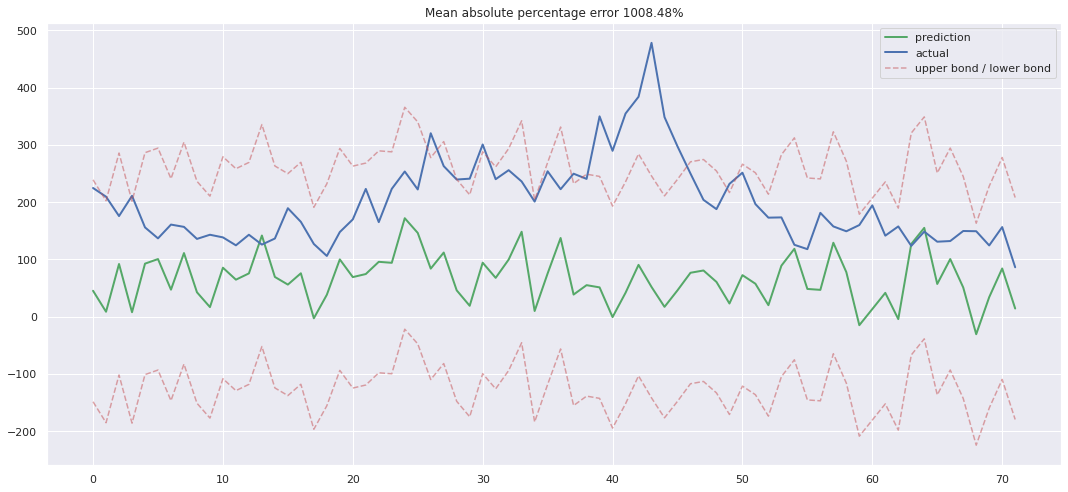

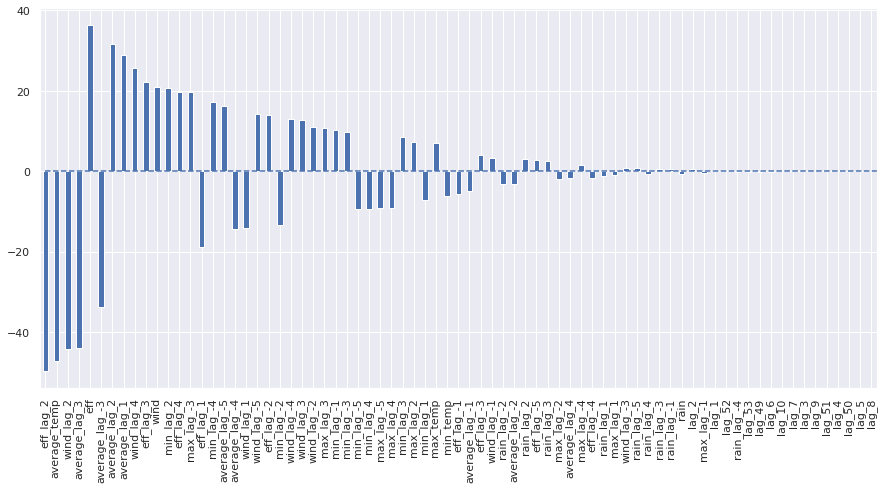

In [185]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

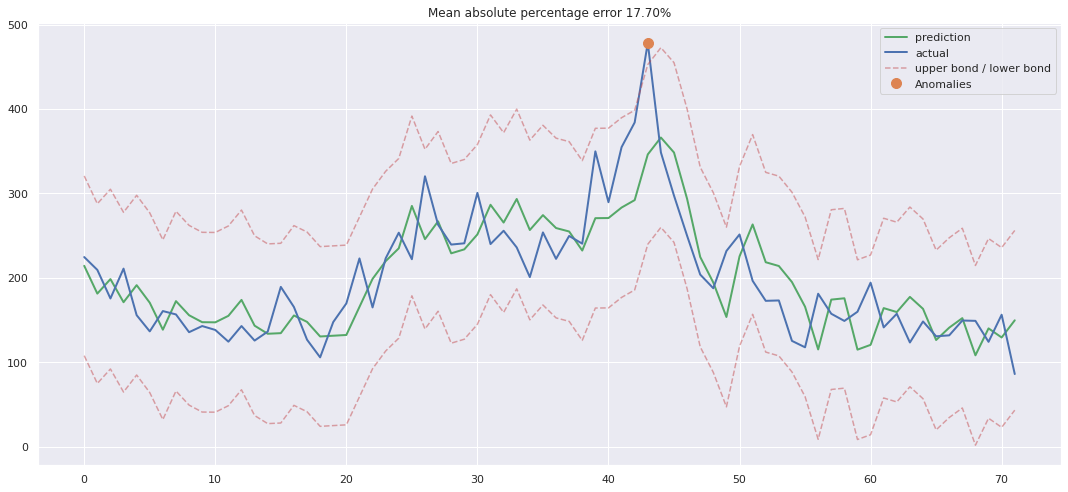

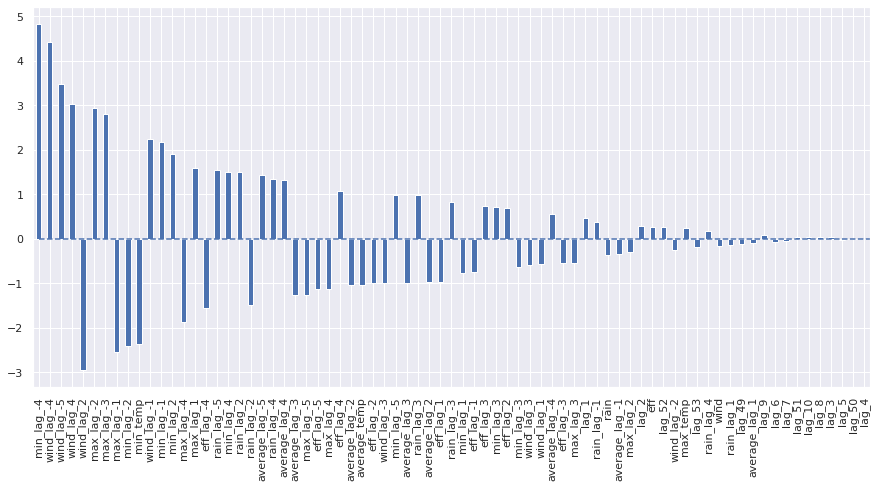

In [186]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(0, 100))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

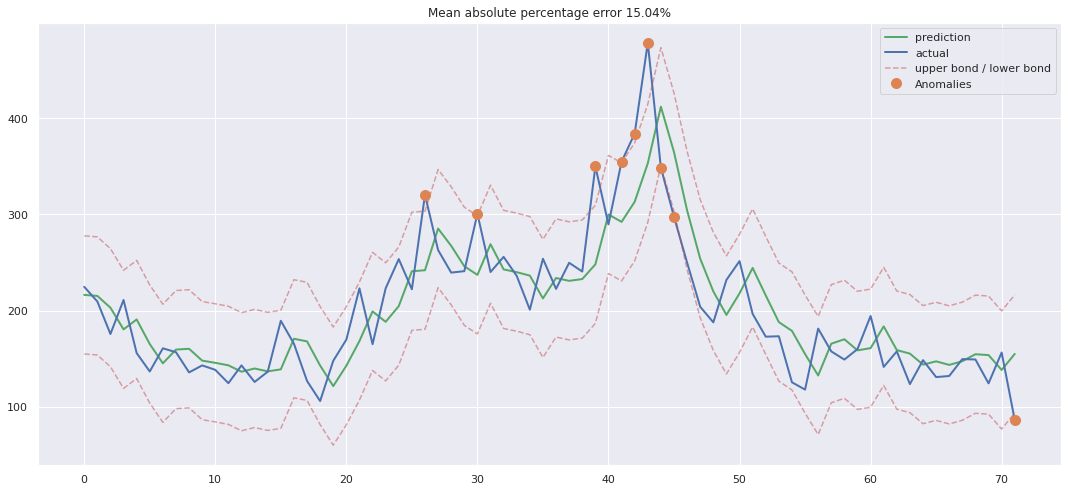

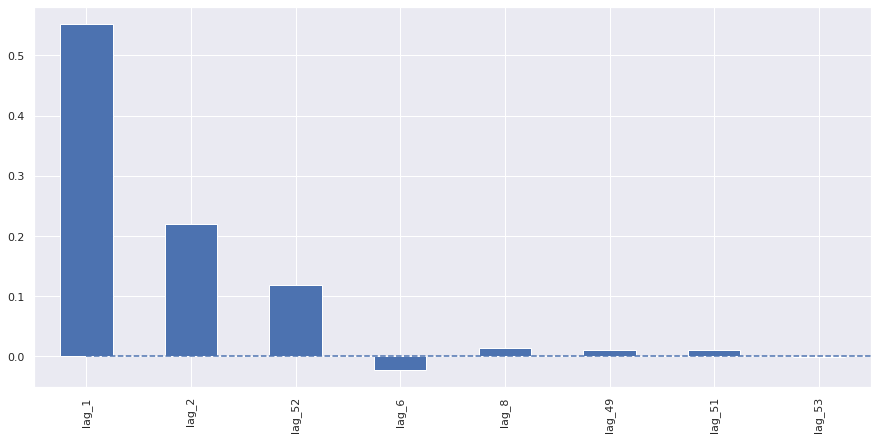

In [187]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso,normas = True)

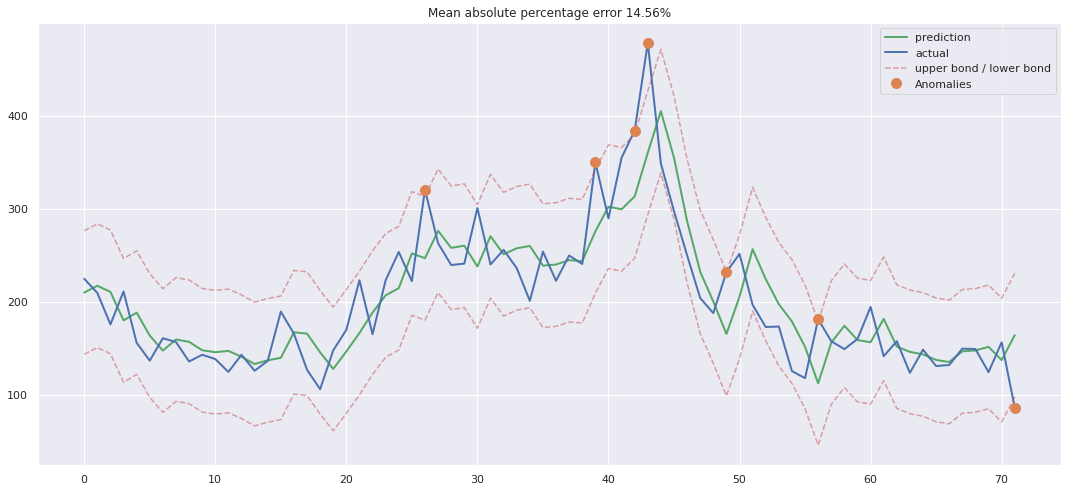

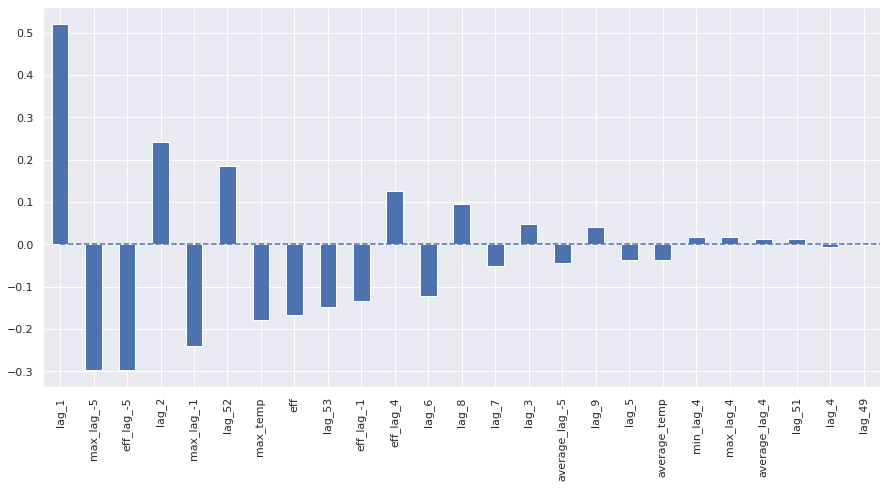

In [188]:
elasticnet = ElasticNetCV(cv=tscv, eps=0.00001,alphas=np.linspace(0, 100))
elasticnet.fit(X_train, y_train)

plotModelResults(elasticnet, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elasticnet,normas = True)

Далее применим методы градиентного бустинга

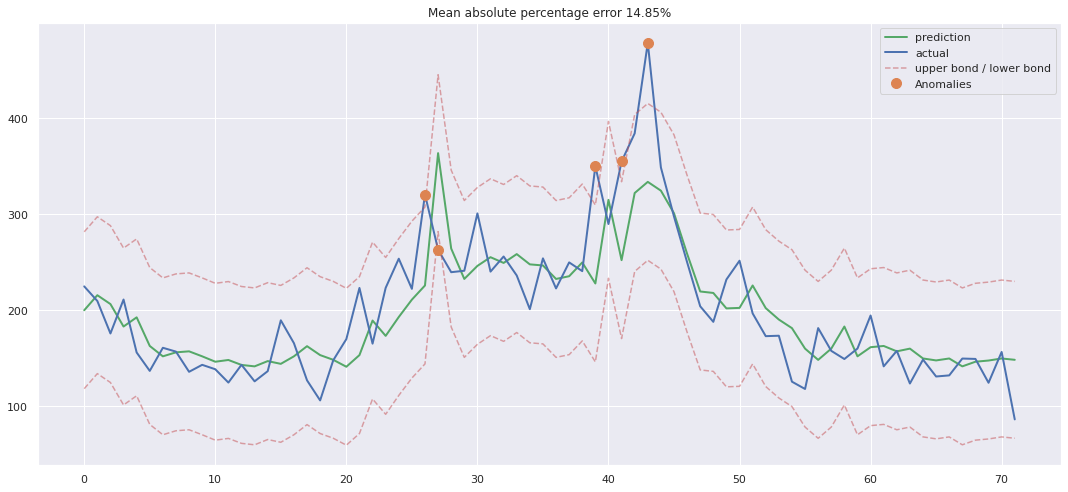

In [393]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

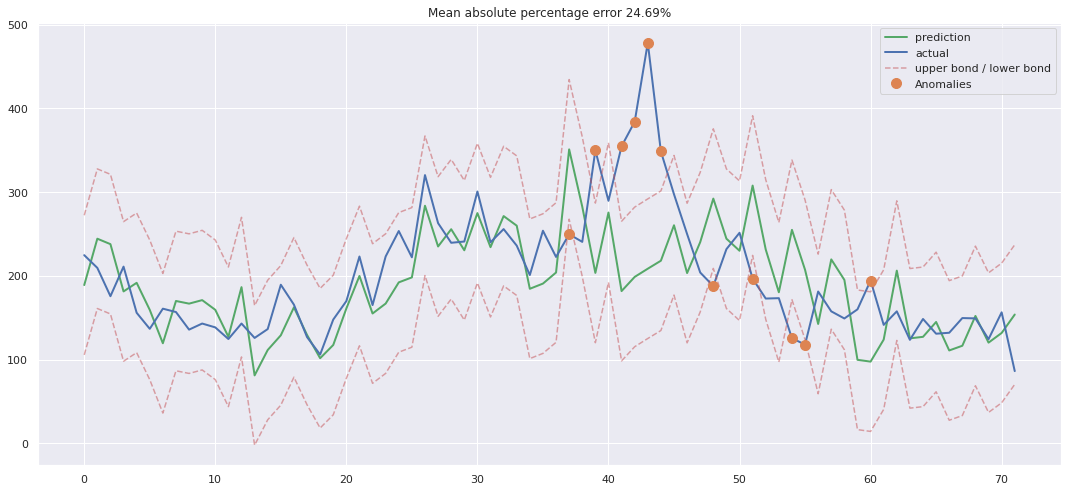

In [394]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='MAPE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Рассмотрим, как работает библиотека Prophet от Facebook

In [200]:
from fbprophet import Prophet

In [395]:
# number of future predictions
predictions = 72
data = update_data()[['datum','N02BE']]
# creating a specific format dataset 
data.columns = ['ds', 'y']
df = data
df.tail()

ds        y
297 2019-09-15  178.375
298 2019-09-22  248.250
299 2019-09-29  336.700
300 2019-10-06  249.450
301 2019-10-13   95.100

In [396]:
# reserve some data for testing
train_df = df[:-predictions]
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='W')
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
297 2019-09-15
298 2019-09-22
299 2019-09-29
300 2019-10-06
301 2019-10-13

In [397]:
# finally, making predictions
forecast = model.predict(future)

Mean absolute percentage error 23.93%


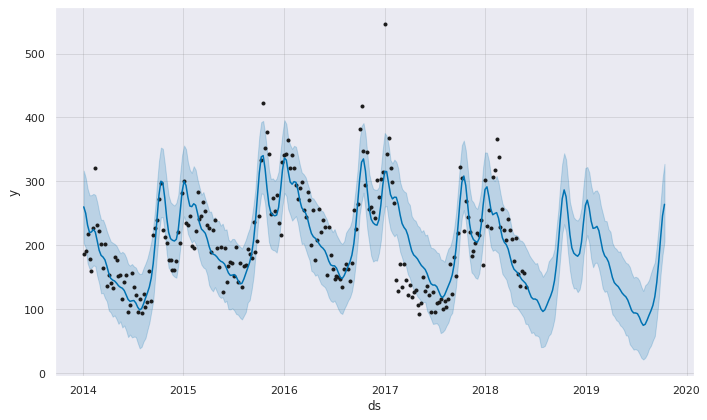

In [398]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

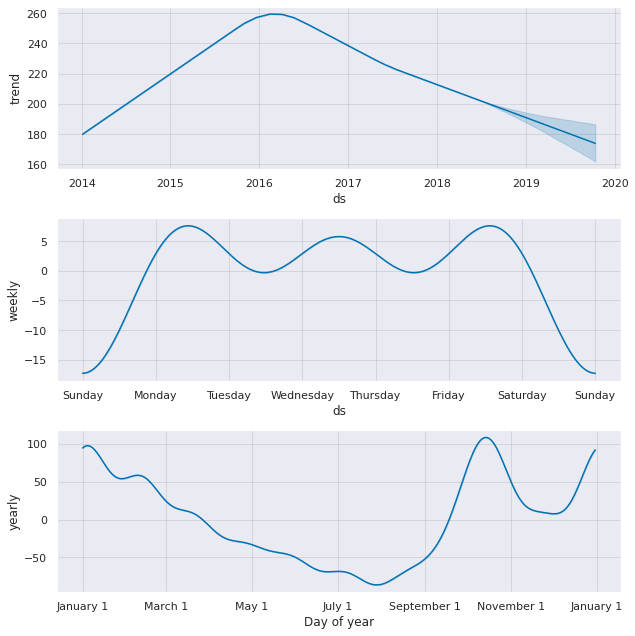

In [399]:
_ = model.plot_components(forecast)

Воспользуемся также библиотекой генерации признаков tsfresh

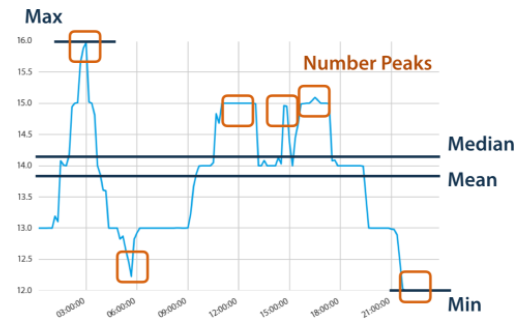

In [249]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

INFO:numba.cuda.cudadrv.driver:init


In [279]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [652]:
data = update_data()[['datum','N02BE']]

In [653]:
# Adding the lag of the target variable from 100 steps back up to 400
data = pd.DataFrame(data.N02BE.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 

In [654]:
data = pd.concat([data,forecast],axis = 1).drop(['ds'],axis = 1)
data = data[:298]

In [655]:
data['min_temp'] = week_weather['min']
data['max_temp'] = week_weather['max']
data['average_temp'] = week_weather.average
data['wind'] = week_weather.wind
data['rain'] = week_weather.rain
data['eff'] = week_weather.eff
vals = list(range(1,5))+list(range(-5,0))
for i in vals:
    data["min_lag_{}".format(i)] = data.min_temp.shift(i)
    data["max_lag_{}".format(i)] = data.max_temp.shift(i)
    data["average_lag_{}".format(i)] = data.average_temp.shift(i)
    data["wind_lag_{}".format(i)] = data.wind.shift(i)
    data["rain_lag_{}".format(i)] = data.rain.shift(i)
    data["eff_lag_{}".format(i)] = data.eff.shift(i)
# take a look at the new dataframe 

In [656]:
y = data.dropna().y
data = data.dropna().drop(['y'], axis=1)

In [657]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

74

In [658]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(22320, 2)


0  1
0  300.22  0
1  282.70  0
2  203.60  0
3  221.58  0
4  175.70  0

In [659]:
X = extract_features(
    data_long, column_id=1, 
    impute_function=impute, 
    default_fc_parameters=settings_comprehensive,
    n_jobs=6
)
print(X.shape)

Feature Extraction: 100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


(240, 787)


In [660]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

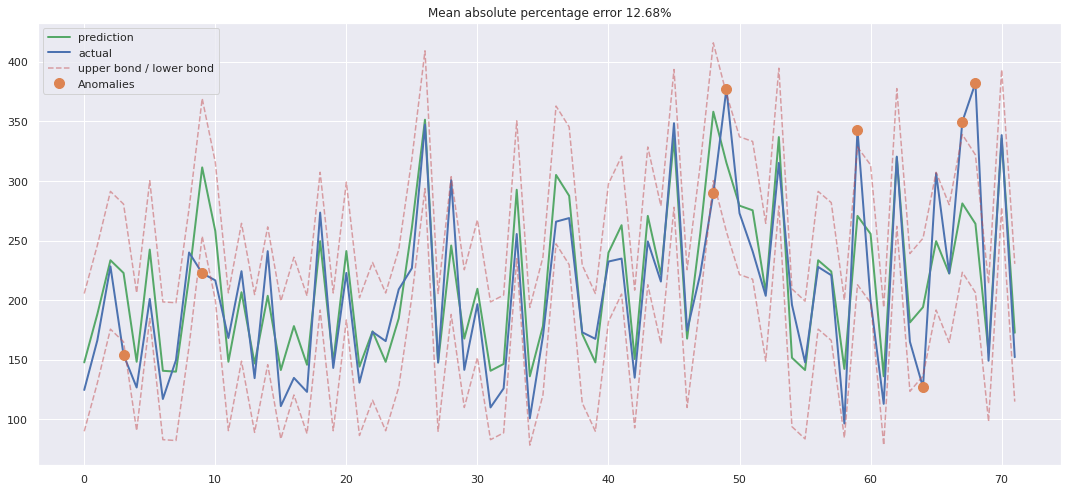

In [661]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

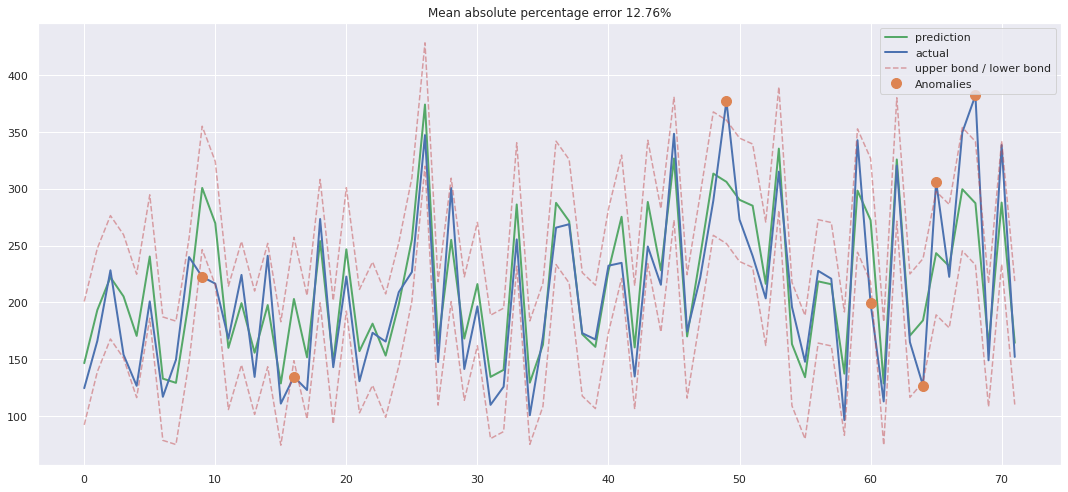

In [667]:
elasticnet.fit(X_train_scaled, y_train)

plotModelResults(elasticnet, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(elasticnet,normas = True)

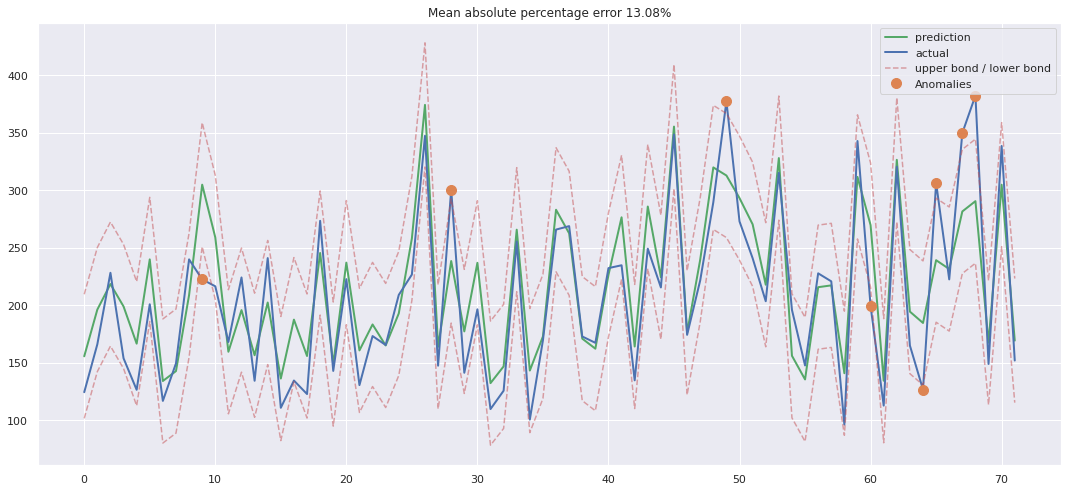

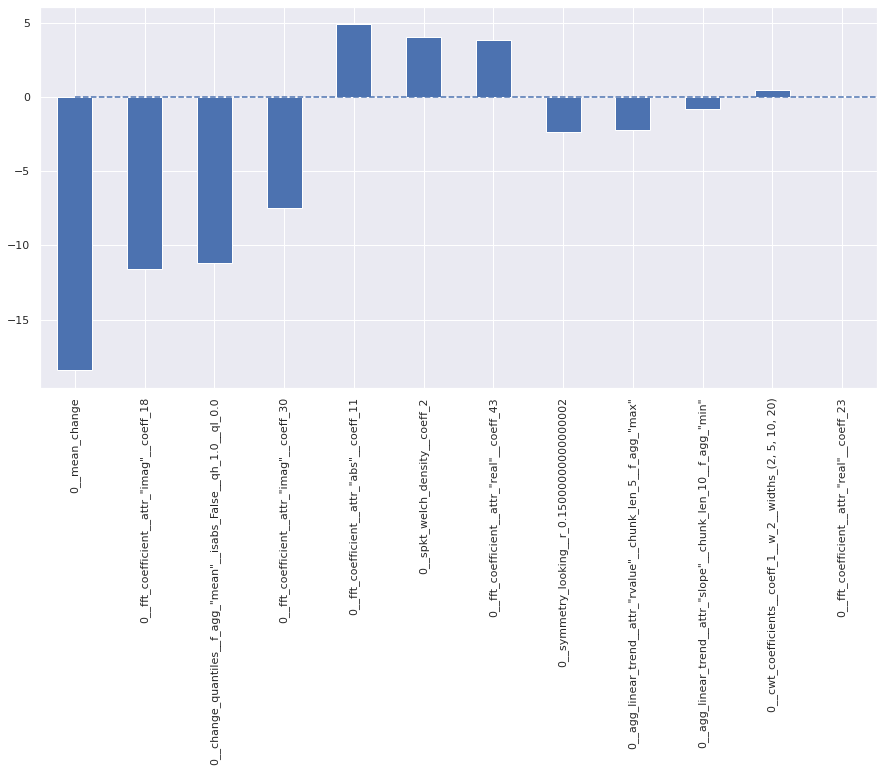

In [668]:
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso,normas = True)

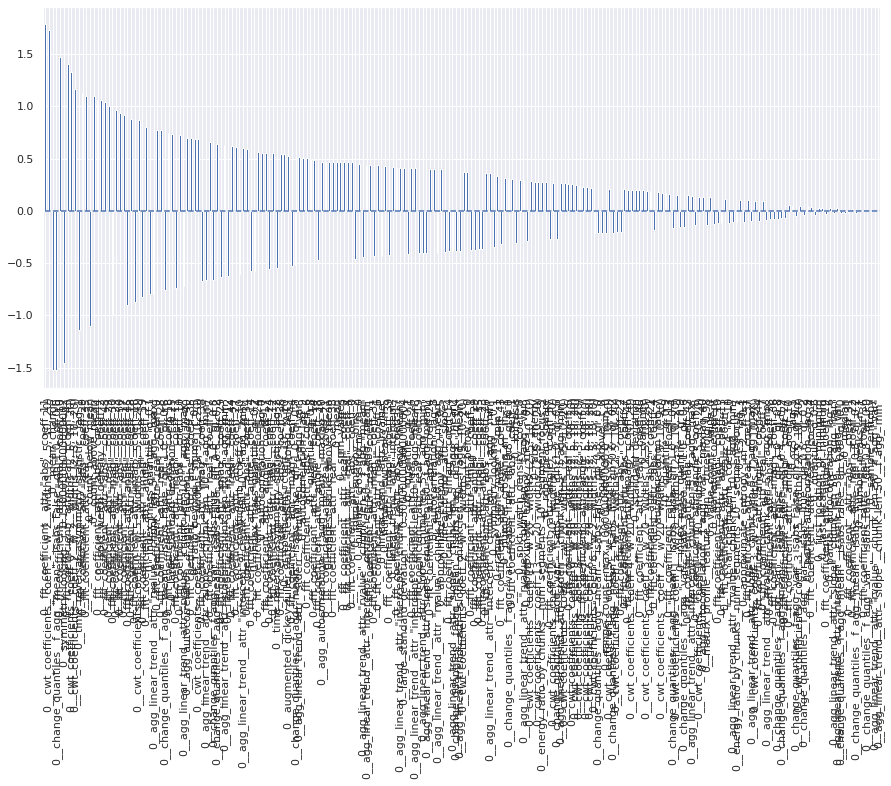

In [669]:
plotCoefficients(elasticnet,normas = True)

In [629]:
data = update_data()[['datum','N02BE']]

In [630]:
# Adding the lag of the target variable from 100 steps back up to 400
data = pd.DataFrame(data.N02BE.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail(7)

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6    lag_7  \
295  117.400  115.450  125.000   86.250  156.450  124.375  149.200  149.600   
296  154.755  117.400  115.450  125.000   86.250  156.450  124.375  149.200   
297  178.375  154.755  117.400  115.450  125.000   86.250  156.450  124.375   
298  248.250  178.375  154.755  117.400  115.450  125.000   86.250  156.450   
299  336.700  248.250  178.375  154.755  117.400  115.450  125.000   86.250   
300  249.450  336.700  248.250  178.375  154.755  117.400  115.450  125.000   
301   95.100  249.450  336.700  248.250  178.375  154.755  117.400  115.450   

       lag_8    lag_9   lag_10   lag_49   lag_50   lag_51   lag_52   lag_53  
295  132.050  130.900  148.500  222.162  253.550  223.200  165.100  223.100  
296  149.600  132.050  130.900  320.350  222.162  253.550  223.200  165.100  
297  149.200  149.600  132.050  262.950  320.350  222.162  253.550  223.200  
298  124.375  149.200  149.600  239.500  262.950  320.350  222.162  253.550  
299  156.450  124.375  149.200  241.000  239.500  262.950  320.350  222.162  
300   86.250  156.450  124.375  300.725  241.000  239.500  262.950  320.350  
301  125.000   86.250  156.450  240.100  300.725  241.000  239.500  262.950

In [631]:
data = data[:298]

In [632]:
data['min_temp'] = week_weather['min']
data['max_temp'] = week_weather['max']
data['average_temp'] = week_weather.average
data['wind'] = week_weather.wind
data['rain'] = week_weather.rain
data['eff'] = week_weather.eff
vals = list(range(1,5))+list(range(-5,0))
for i in vals:
    data["min_lag_{}".format(i)] = data.min_temp.shift(i)
    data["max_lag_{}".format(i)] = data.max_temp.shift(i)
    data["average_lag_{}".format(i)] = data.average_temp.shift(i)
    data["wind_lag_{}".format(i)] = data.wind.shift(i)
    data["rain_lag_{}".format(i)] = data.rain.shift(i)
    data["eff_lag_{}".format(i)] = data.eff.shift(i)
# take a look at the new dataframe 
data.head()

y   lag_1   lag_2   lag_3   lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
0  185.95     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
1  190.70  185.95     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2  218.40  190.70  185.95     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
3  179.60  218.40  190.70  185.95     NaN    NaN    NaN    NaN    NaN    NaN   
4  159.88  179.60  218.40  190.70  185.95    NaN    NaN    NaN    NaN    NaN   

   ...  average_lag_-2  wind_lag_-2  rain_lag_-2  eff_lag_-2  min_lag_-1  \
0  ...            6.90         3.57         2.00        3.73        4.70   
1  ...           -3.77         5.29         1.29       -9.37        4.93   
2  ...            3.36         5.71         0.00       -1.81       -5.91   
3  ...            9.57         3.57         0.86        6.41        0.11   
4  ...           11.20         2.43         0.14        9.23        5.51   

   max_lag_-1  average_lag_-1  wind_lag_-1  rain_lag_-1  eff_lag_-1  
0       12.59            8.63         2.57         0.14        6.01  
1        9.04            6.90         3.57         2.00        3.73  
2       -1.10           -3.77         5.29         1.29       -9.37  
3        7.76            3.36         5.71         0.00       -1.81  
4       14.93            9.57         3.57         0.86        6.41  

[5 rows x 76 columns]

In [633]:
y = data.dropna().y
data = data.dropna().drop(['y'], axis=1)

In [634]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

74

In [635]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(18000, 2)


0  1
0  300.22  0
1  282.70  0
2  203.60  0
3  221.58  0
4  175.70  0

In [636]:
X = extract_features(
    data_long, column_id=1, 
    impute_function=impute, 
    default_fc_parameters=settings_comprehensive,
    n_jobs=6
)
print(X.shape)

Feature Extraction: 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


(240, 787)


In [637]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

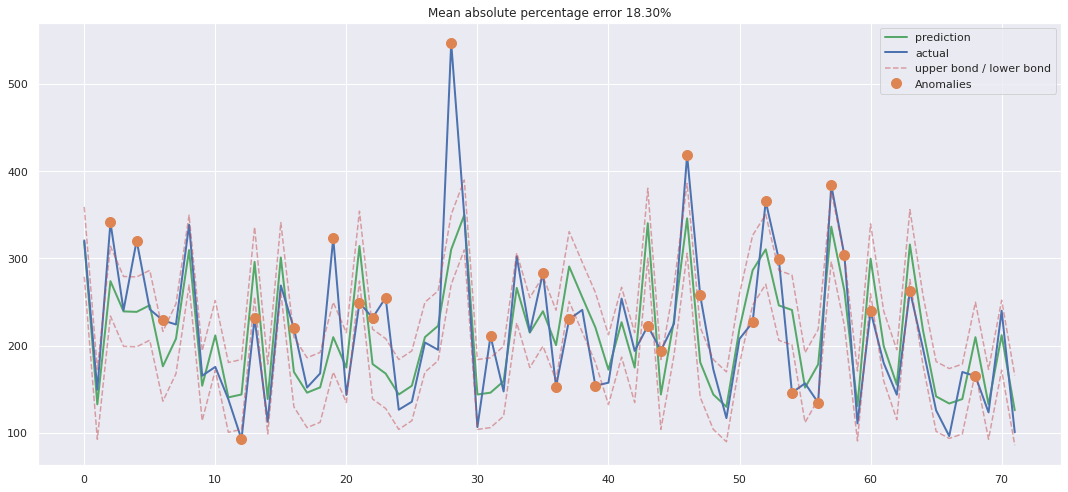

In [638]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)